# VAE for MNIST  

The purpose of this demo is to help you learn about variational autoencoder. The algorithm is being implemented is from the paper "Auto-Encoding Variational Bayes", by Diederik P Kingma, Max Welling (https://arxiv.org/abs/1312.6114).

Followed the logic of example vae come with PyTorch distribution in https://github.com/pytorch/examples/blob/master/vae/main.py.

You are free to change model acrhitecture, or any part of the logic. 

If you have any suggestions or find errors, please, don't be hesitate to email me at jayanta.jayantamukherjee@gmail.com


In [1]:
from __future__ import print_function
import argparse
import torch
from torch.autograd import Variable
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

## Define VAE Class

In [2]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [3]:
parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

/home/jay/.conda/envs/jay/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


#### Modeling Loss
Reconstruction + KL divergence losses summed over all elements and batch

In [4]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [5]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

#### Test VAE

In [6]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

#### Running VAE Model

In [7]:
if __name__ == "__main__":
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.571960
Train Epoch: 1 [1280/60000 (2%)]	Loss: 291.882019
Train Epoch: 1 [2560/60000 (4%)]	Loss: 241.955002
Train Epoch: 1 [3840/60000 (6%)]	Loss: 212.320740
Train Epoch: 1 [5120/60000 (9%)]	Loss: 214.543991
Train Epoch: 1 [6400/60000 (11%)]	Loss: 216.663116
Train Epoch: 1 [7680/60000 (13%)]	Loss: 201.579803
Train Epoch: 1 [8960/60000 (15%)]	Loss: 195.256744
Train Epoch: 1 [10240/60000 (17%)]	Loss: 197.438828
Train Epoch: 1 [11520/60000 (19%)]	Loss: 189.910568
Train Epoch: 1 [12800/60000 (21%)]	Loss: 185.966095
Train Epoch: 1 [14080/60000 (23%)]	Loss: 181.120499
Train Epoch: 1 [15360/60000 (26%)]	Loss: 169.185745
Train Epoch: 1 [16640/60000 (28%)]	Loss: 166.216782
Train Epoch: 1 [17920/60000 (30%)]	Loss: 166.638336
Train Epoch: 1 [19200/60000 (32%)]	Loss: 164.184158
Train Epoch: 1 [20480/60000 (34%)]	Loss: 167.744049
Train Epoch: 1 [21760/60000 (36%)]	Loss: 154.769089
Train Epoch: 1 [23040/60000 (38%)]	Loss: 153.823181
Train Epoch: 1 [24320/60000 

Train Epoch: 4 [17920/60000 (30%)]	Loss: 117.983513
Train Epoch: 4 [19200/60000 (32%)]	Loss: 107.308495
Train Epoch: 4 [20480/60000 (34%)]	Loss: 116.834656
Train Epoch: 4 [21760/60000 (36%)]	Loss: 117.640274
Train Epoch: 4 [23040/60000 (38%)]	Loss: 117.188141
Train Epoch: 4 [24320/60000 (41%)]	Loss: 114.023590
Train Epoch: 4 [25600/60000 (43%)]	Loss: 111.495850
Train Epoch: 4 [26880/60000 (45%)]	Loss: 114.224274
Train Epoch: 4 [28160/60000 (47%)]	Loss: 111.411781
Train Epoch: 4 [29440/60000 (49%)]	Loss: 109.420708
Train Epoch: 4 [30720/60000 (51%)]	Loss: 103.320969
Train Epoch: 4 [32000/60000 (53%)]	Loss: 108.005959
Train Epoch: 4 [33280/60000 (55%)]	Loss: 112.992325
Train Epoch: 4 [34560/60000 (58%)]	Loss: 107.840591
Train Epoch: 4 [35840/60000 (60%)]	Loss: 117.426643
Train Epoch: 4 [37120/60000 (62%)]	Loss: 110.101624
Train Epoch: 4 [38400/60000 (64%)]	Loss: 113.872559
Train Epoch: 4 [39680/60000 (66%)]	Loss: 114.759079
Train Epoch: 4 [40960/60000 (68%)]	Loss: 109.668068
Train Epoch:

Train Epoch: 7 [35840/60000 (60%)]	Loss: 111.149063
Train Epoch: 7 [37120/60000 (62%)]	Loss: 110.014717
Train Epoch: 7 [38400/60000 (64%)]	Loss: 101.231873
Train Epoch: 7 [39680/60000 (66%)]	Loss: 110.390381
Train Epoch: 7 [40960/60000 (68%)]	Loss: 107.546425
Train Epoch: 7 [42240/60000 (70%)]	Loss: 104.230209
Train Epoch: 7 [43520/60000 (72%)]	Loss: 107.413704
Train Epoch: 7 [44800/60000 (75%)]	Loss: 106.638268
Train Epoch: 7 [46080/60000 (77%)]	Loss: 104.761429
Train Epoch: 7 [47360/60000 (79%)]	Loss: 108.106873
Train Epoch: 7 [48640/60000 (81%)]	Loss: 106.983551
Train Epoch: 7 [49920/60000 (83%)]	Loss: 102.710205
Train Epoch: 7 [51200/60000 (85%)]	Loss: 103.932655
Train Epoch: 7 [52480/60000 (87%)]	Loss: 102.515167
Train Epoch: 7 [53760/60000 (90%)]	Loss: 107.715500
Train Epoch: 7 [55040/60000 (92%)]	Loss: 103.997047
Train Epoch: 7 [56320/60000 (94%)]	Loss: 108.708130
Train Epoch: 7 [57600/60000 (96%)]	Loss: 107.148682
Train Epoch: 7 [58880/60000 (98%)]	Loss: 107.822922
====> Epoch:

Train Epoch: 10 [53760/60000 (90%)]	Loss: 105.661972
Train Epoch: 10 [55040/60000 (92%)]	Loss: 104.238968
Train Epoch: 10 [56320/60000 (94%)]	Loss: 102.780594
Train Epoch: 10 [57600/60000 (96%)]	Loss: 110.743851
Train Epoch: 10 [58880/60000 (98%)]	Loss: 109.764740
====> Epoch: 10 Average loss: 105.9525
====> Test set loss: 105.2553


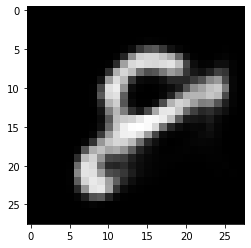

In [8]:
input_dim = 28 * 28
for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        inputs = Variable(data.resize_(args.batch_size, input_dim))

modeled_data = model(inputs)
model_data = modeled_data[0].reshape(args.batch_size, input_dim)
#print(input_data)        
plt.imshow(model_data[0].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

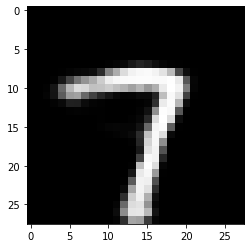

In [9]:
plt.imshow(model_data[1].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

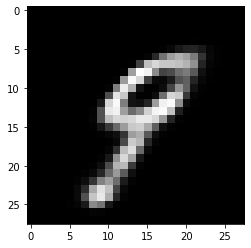

In [10]:
plt.imshow(model_data[2].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

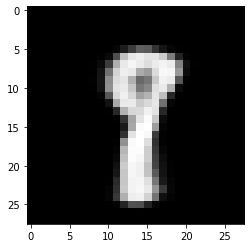

In [11]:
plt.imshow(model_data[3].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

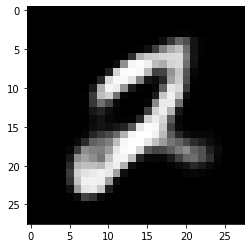

In [12]:
plt.imshow(model_data[4].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

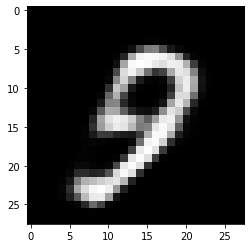

In [13]:
plt.imshow(model_data[5].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

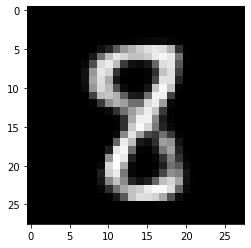

In [14]:
plt.imshow(model_data[6].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

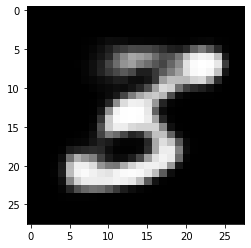

In [15]:
plt.imshow(model_data[7].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

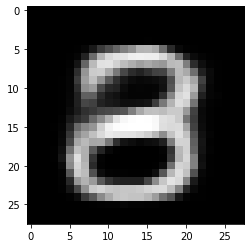

In [16]:
plt.imshow(model_data[8].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

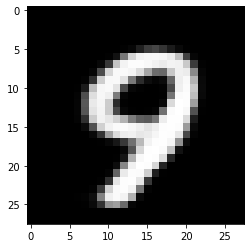

In [17]:
plt.imshow(model_data[9].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

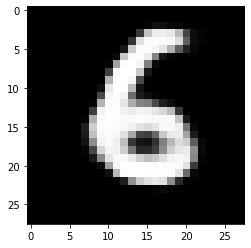

In [18]:
plt.imshow(model_data[10].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

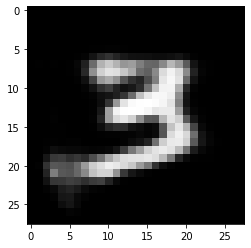

In [19]:
plt.imshow(model_data[11].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

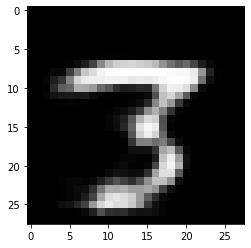

In [20]:
plt.imshow(model_data[12].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

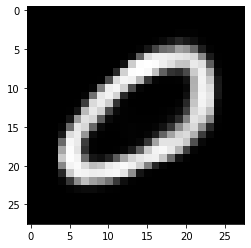

In [21]:
plt.imshow(model_data[13].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

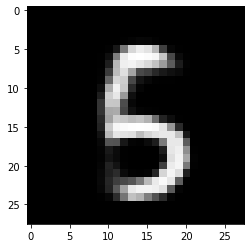

In [22]:
plt.imshow(model_data[14].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

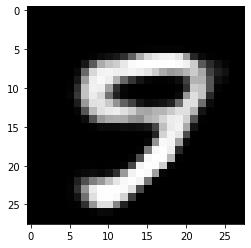

In [23]:
plt.imshow(model_data[15].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

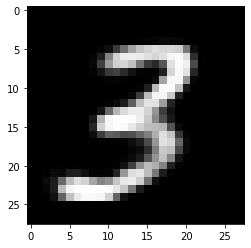

In [24]:
plt.imshow(model_data[16].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

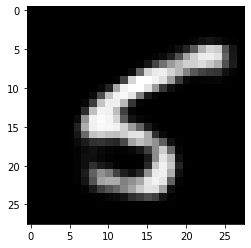

In [25]:
plt.imshow(model_data[17].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

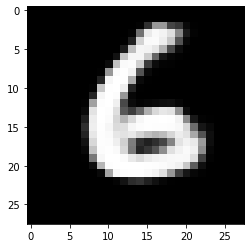

In [26]:
plt.imshow(model_data[18].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

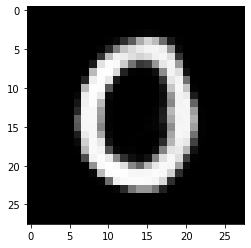

In [27]:
plt.imshow(model_data[19].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

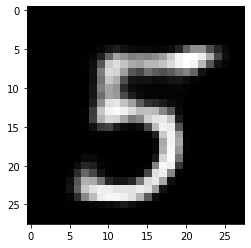

In [28]:
plt.imshow(model_data[20].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

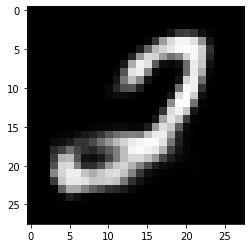

In [29]:
plt.imshow(model_data[21].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

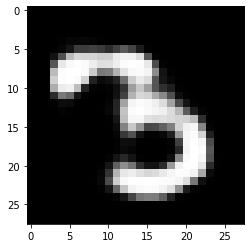

In [30]:
plt.imshow(model_data[22].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

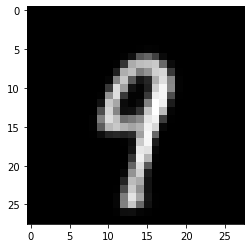

In [31]:
plt.imshow(model_data[23].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

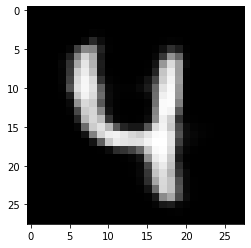

In [32]:
plt.imshow(model_data[24].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

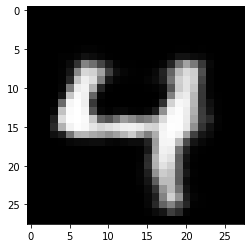

In [33]:
plt.imshow(model_data[25].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

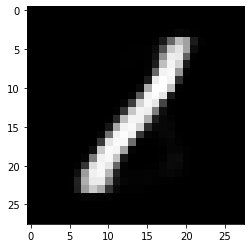

In [34]:
plt.imshow(model_data[26].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

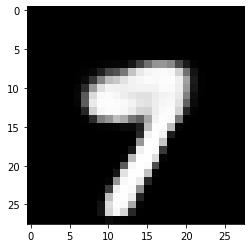

In [35]:
plt.imshow(model_data[27].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

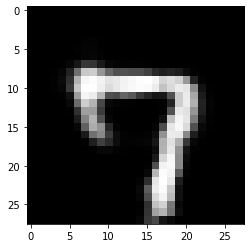

In [36]:
plt.imshow(model_data[28].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

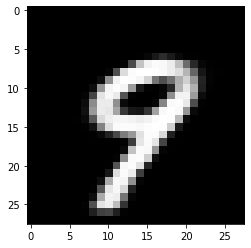

In [37]:
plt.imshow(model_data[29].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

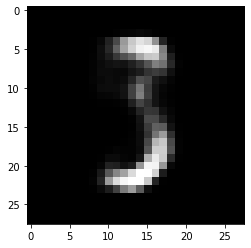

In [38]:
plt.imshow(model_data[30].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

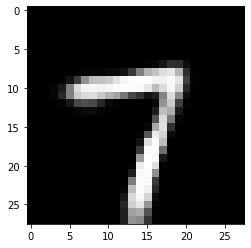

In [39]:
plt.imshow(model_data[31].detach().numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)